# Scale-Alibi Training Test

The purpose of this notebook is to try to get the scale-alibi code training, which includes a test of the dataset loading code.

In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
from pathlib import Path

import random
from scale_alibi.dataset.loader import (
    MultimodalDataset,
    PMTileDataset,
    PMTile4xDataset,
    RemoveChannels,
    LoresMultimodalDataset,
    ChannelsFirstImageOrder,
    HalfResolution
)

from torchvision.transforms import Compose
from pmtiles.tile import tileid_to_zxy
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 300
import einops

import numpy as np



LORES_DATASET_PATH_SMALL = Path('../rasters/final/visual_tiles_small.pmtile')
RADAR_DATASET_PATH_SMALL = Path('../rasters/final/sar_tiles_small.pmtile')
HIRES_DATASET_PATH_SMALL = Path('../rasters/final/hires_visual_small.pmtile')
LORES_DATASET_PATH = Path('../rasters/final/visual_tiles.pmtile')
RADAR_DATASET_PATH = Path('../rasters/final/sar_tiles.pmtile')
HIRES_DATASET_PATH = Path('../rasters/final/hires_visual.pmtile')

## load some samples

Loading the datasets.

In [3]:
lores_dset = PMTileDataset(
    LORES_DATASET_PATH_SMALL,
    transform=Compose([
        RemoveChannels([3]), # remove alpha
        HalfResolution(),
        ChannelsFirstImageOrder()
    ])
)
radar_dset = PMTileDataset(
    RADAR_DATASET_PATH_SMALL,
    # transform=RemoveChannels([0,3])
    transform=Compose([
        RemoveChannels([0, 3]), # remove alpha and empty red channel
        HalfResolution(),
        ChannelsFirstImageOrder()
    ])
)

hires_dset = PMTileDataset(
    HIRES_DATASET_PATH_SMALL,
    transform=Compose([
        RemoveChannels([3]), # hires may or may not actually bundle an alpha channel
        HalfResolution(),
        ChannelsFirstImageOrder()
    ])
)

hires_4x_dset = PMTile4xDataset(hires_dset)

# lores_dset_test = PMTileDataset(LORES_DATASET_PATH_SMALL)
# radar_dset_test = PMTileDataset(RADAR_DATASET_PATH_SMALL)
# hires_dset_test = PMTileDataset(HIRES_DATASET_PATH_SMALL)

In [4]:
print('hires train tiles:', len(hires_dset))
print('hires 4x    tiles:', len(hires_4x_dset))
print('lores train tiles:', len(lores_dset))
print('radar train tiles:', len(radar_dset))

# print('hires test tiles:', len(hires_dset_test))
# print('lores test tiles:', len(lores_dset_test))
# print('radar test tiles:', len(radar_dset_test))

hires train tiles: 109585
hires 4x    tiles: 109585
lores train tiles: 21917
radar train tiles: 83407


In [5]:
mmset_train = MultimodalDataset(
    radar_dset,
    lores_dset,
    hires_dset,
    hires_4x_dset
)

# mmset_train = LoresMultimodalDataset(
#     radar_dset,
#     lores_dset,
#     # hires_dset
# )

# mmset_test = MultimodalDataset(
#     radar_dset_test,
#     lores_dset_test,
#     hires_dset_test
# )

In [6]:
print('joint tiles:     ', len(mmset_train))
# print('joint test tiles:', len(mmset_test))

# print('train/test overlap', len(set(mmset_train.tile_ids) & set(mmset_test.tile_ids)))


joint tiles:      21497


In [7]:
sample = mmset_train[0]

# print(f'data shapes:\n\tradar: {sample.radar.shape}\n\tlores: {sample.lores.shape}\n\thires: {sample.hires.shape}')
print(f'data shapes:\n\tradar: {sample.radar.shape}\n\tlores: {sample.lores.shape}\n\thires: {sample.hires.shape}\n\thir4x: {sample.hir4x.shape}')

data shapes:
	radar: (2, 128, 128)
	lores: (3, 128, 128)
	hires: (3, 128, 128)
	hir4x: (3, 256, 256)


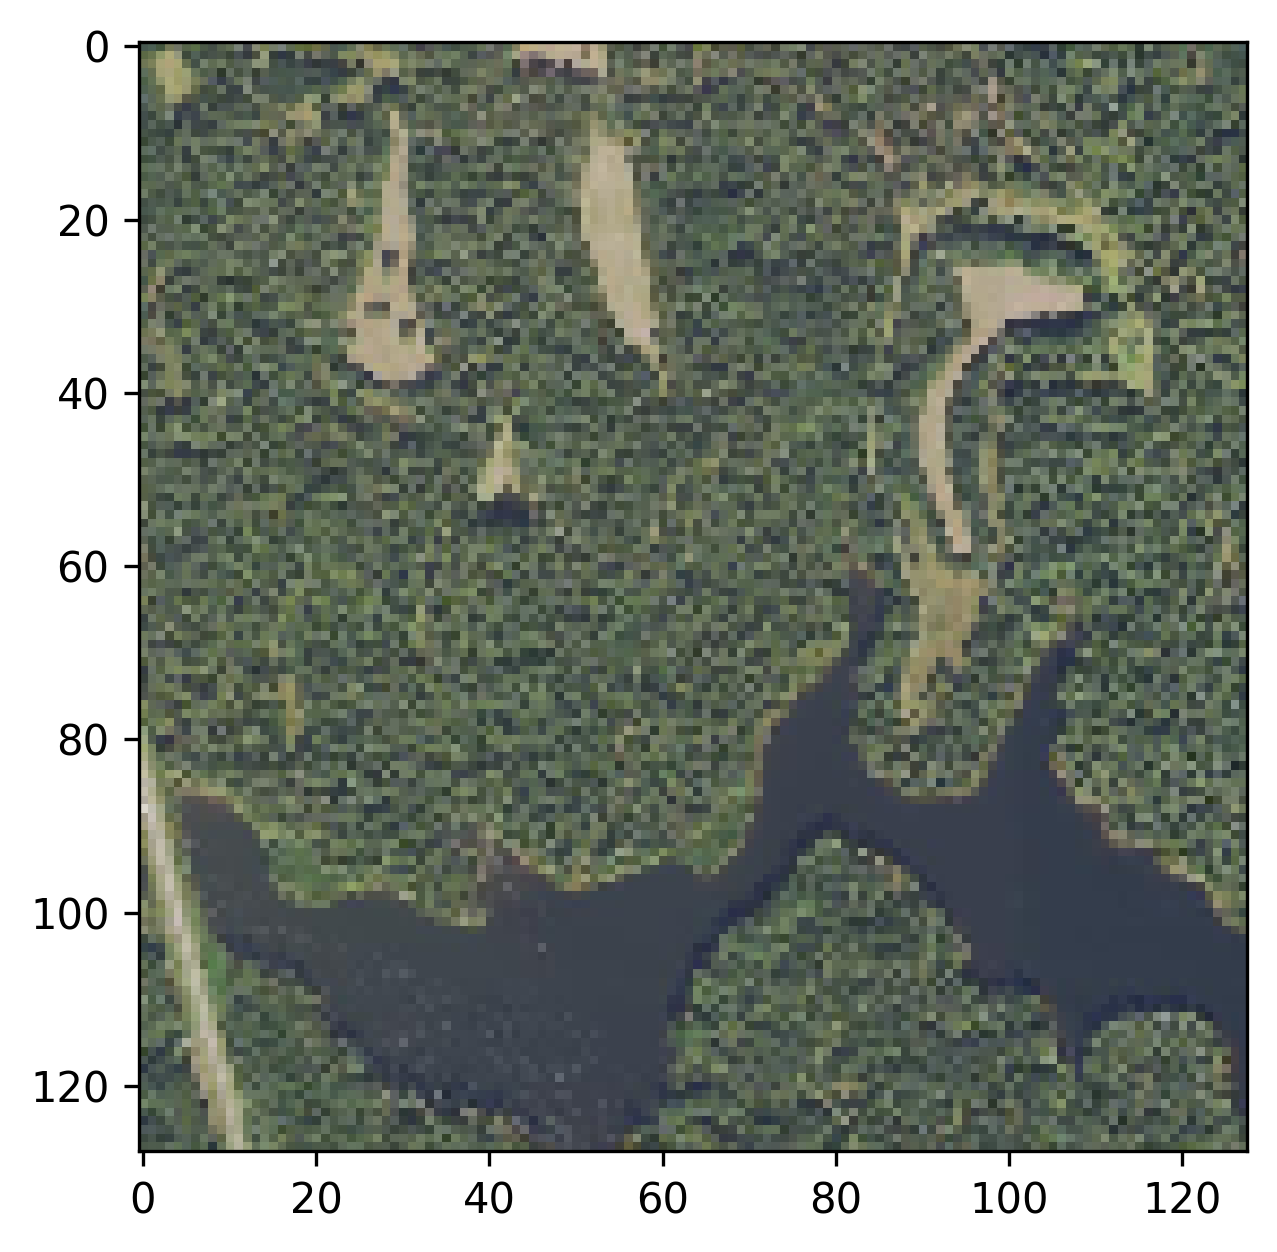

In [9]:
plt.imshow(
    einops.rearrange(sample.hir4x[:,::2,::2], 'c h w -> h w c')
)
# plt.imshow(einops.rearrange(sample.hir4x[:,::2,::2], 'c h w -> h w c')

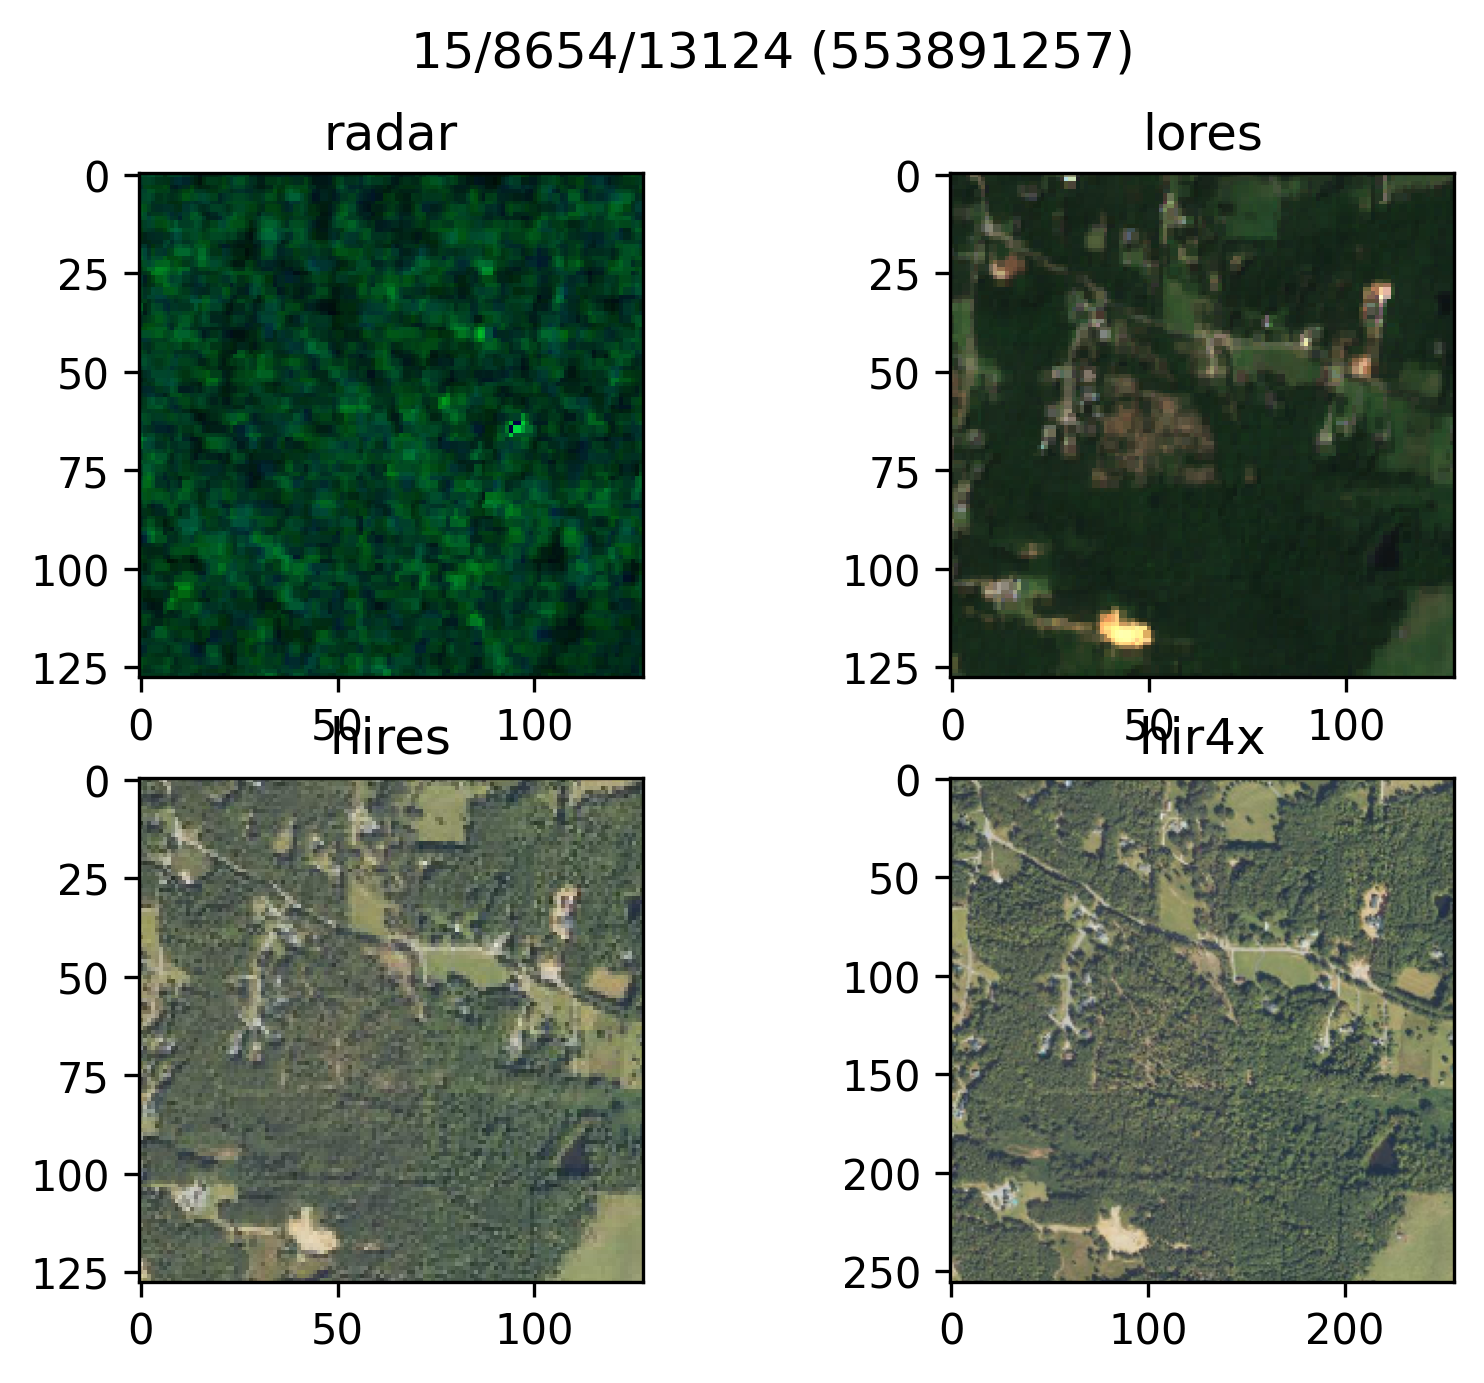

In [11]:
def show_sample(sample):
    fig, axs = plt.subplots(2,2)
    
    z,x,y = tileid_to_zxy(sample.tile_id)
    
    fig.suptitle(f'{z}/{x}/{y} ({sample.tile_id})')
    
    reorder_channels = lambda img: einops.rearrange(img, 'c h w -> h w c')
    
    
    axs = axs.flatten()
    
    
    # process radar to add back in the red channel (so it's displayable)
    radar = reorder_channels(sample.radar)
    radar = np.stack(
        [
            np.zeros_like(radar[:,:,0]),
            radar[:,:,0],
            radar[:,:,1]
        ],
        axis=-1
    )
    
    axs[0].set_title('radar')
    axs[0].imshow(
        radar
    )
    
    axs[1].set_title('lores')
    axs[1].imshow(reorder_channels(sample.lores))
    
    axs[2].set_title('hires')
    axs[2].imshow(
        reorder_channels(sample.hires)
    )
    
    axs[3].set_title('hir4x')
    axs[3].imshow(
        reorder_channels(sample.hir4x)
    )
    
    plt.show()

random_idx = random.choice(range(len(mmset_train)))
    
show_sample(mmset_train[random_idx])

## training loop

In [12]:
from scale_alibi.model import ScaleAlibi, get_mask, get_scale_alibi
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist

from torch.cuda.amp import GradScaler, autocast

from dataclasses import dataclass

print('distributed processing available?:', dist.is_available())

distributed processing available?: True


In [13]:
# %%time
# alibi_1 = get_alibi(8,256)

In [14]:
%%time
get_scale_alibi(8, 1024, scale_multiplier=1)

CPU times: user 18.1 ms, sys: 43.8 ms, total: 61.9 ms
Wall time: 16.2 ms


tensor([[[[-0.0000e+00, -5.0000e-01, -1.0000e+00,  ..., -2.1225e+01,
           -2.1570e+01, -2.1920e+01],
          [-5.0000e-01, -0.0000e+00, -5.0000e-01,  ..., -2.0887e+01,
           -2.1225e+01, -2.1570e+01],
          [-1.0000e+00, -5.0000e-01, -0.0000e+00,  ..., -2.0555e+01,
           -2.0887e+01, -2.1225e+01],
          ...,
          [-2.1225e+01, -2.0887e+01, -2.0555e+01,  ..., -0.0000e+00,
           -5.0000e-01, -1.0000e+00],
          [-2.1570e+01, -2.1225e+01, -2.0887e+01,  ..., -5.0000e-01,
           -0.0000e+00, -5.0000e-01],
          [-2.1920e+01, -2.1570e+01, -2.1225e+01,  ..., -1.0000e+00,
           -5.0000e-01, -0.0000e+00]],

         [[-0.0000e+00, -2.5000e-01, -5.0000e-01,  ..., -1.0612e+01,
           -1.0785e+01, -1.0960e+01],
          [-2.5000e-01, -0.0000e+00, -2.5000e-01,  ..., -1.0443e+01,
           -1.0612e+01, -1.0785e+01],
          [-5.0000e-01, -2.5000e-01, -0.0000e+00,  ..., -1.0277e+01,
           -1.0443e+01, -1.0612e+01],
          ...,
     

In [15]:
# parameters

@dataclass
class ScaleAlibiParams:
    # probably need to change these for your hardware
    # lores_dataset_path: Path # TODO: uncomment
    # radar_dataset_path: Path
    # hires_dataset_path: Path
    
    batch_size: int = 2
    
    # hyperparams, total guess for now
    # croma_inherited
    mask_ratio: float = 0.5 # mask ratio (ratio of patches in a sequence to keep)
    epochs: int = 10
    learning_rate: float = 1e4

    # probably shouldn't change these
    total_channels: int = 8
    num_patches: int = 256
    patch_size: int = 8

    # remove this
    device = 'cpu'

def setup(rank, world_size):
    # Initialize the process group
    # dist.init_process_group(backend='nccl', init_method='env://', world_size=world_size, rank=rank)

    store = dist.HashStore()
    
    # gloo for cpu
    dist.init_process_group(
        backend='gloo',
        # init_method='env://',
        store=store,
        world_size=world_size,
        rank=rank
    )
    
    return store

def cleanup():
    # Clean up the process group
    dist.destroy_process_group()


def train(rank: int, world_size: int, args: ScaleAlibiParams):
    print(f'training starting with rank {rank} (world {world_size})')
    
    # for
    model = ScaleAlibi(
        # ... defaults should be okay
        total_channels=args.total_channels, # 2 sar, 3 lores_visual, 3 hires visual
        num_patches=args.num_patches,
        patch_size=args.patch_size
    )
    model.to(args.device)

#     print(
#         'croma weight types',
#         croma.radar_encoder.linear_input.weight.dtype
#     )


    dataset = mmset_train #TileDataset() # ...
    
    loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
    optimizer = Adam(model.parameters(), lr=args.learning_rate)

    

    model = DDP(model)

    epochs = 10
    for epoch in range(epochs):
        model.train()  # Set the model to training mode

        for batch in loader:
            # print(batch)
            print(f'data shapes:\n\tradar: {batch.radar.shape}\n\tlores: {batch.lores.shape}\n\thir4x: {batch.hir4x.shape}')
            # get mask creates a mask for the MAE based on the number
            # of patches (seq_len) and a ratio of patches to keep
            seq_len = args.num_patches
            radar_mask = get_mask(
                args.batch_size,
                seq_len,
                args.device,
                args.mask_ratio
            )
            print('radar_mask.mask_for_mae', radar_mask['mask_for_mae'].shape)
            optical_mask = get_mask(
                args.batch_size,
                seq_len,
                args.device,
                args.mask_ratio
            )
            print('optic_mask.mask_for_mae', optical_mask['mask_for_mae'].shape)

            hires_mask = get_mask(
                args.batch_size,
                seq_len * 4,
                args.device,
                args.mask_ratio,
                downsize_for_mae=True
            )
            print('hires_mask.mask_for_mae', hires_mask['mask_for_mae'].shape)


            radar_imgs = batch.radar.float().to(args.device)
            lores_imgs = batch.lores.float().to(args.device)
            hires_imgs = batch.hir4x.float().to(args.device)

            optimizer.zero_grad()

            # TODO : finish this
            contrastive_loss, mae_loss = model(
                radar_imgs,
                lores_imgs,
                hires_imgs,
                radar_mask,
                optical_mask,
                hires_mask,
                rank,
                world_size
            )
            
            print(contrastive_loss, mae_loss)

            break
        break
        
if not dist.is_initialized():
    store = setup(0,1)

train(0,1, ScaleAlibiParams())

training starting with rank 0 (world 1)
data shapes:
	radar: torch.Size([2, 2, 128, 128])
	lores: torch.Size([2, 3, 128, 128])
	hir4x: torch.Size([2, 3, 256, 256])
radar_mask.mask_for_mae torch.Size([2, 256])
optic_mask.mask_for_mae torch.Size([2, 256])
hires_mask.mask_for_mae torch.Size([2, 256])
target torch.Size([2, 256, 512])
tensor(0.6902, grad_fn=<DivBackward0>) tensor(4.0126, grad_fn=<AddBackward0>)


Considering this good enough for now.